In [55]:
import json
from pathlib import Path
import pandas as pd
from matplotlib import pyplot as plt

In [56]:
# Read the results and summarize

# Read the latest results file
files = sorted(Path(".").glob("results-*.json"))
filename = files[-1]

file_path = Path(filename)  # change to your file path

with file_path.open("r", encoding="utf-8") as f:
    data = json.load(f)

# Normalize common JSON shapes to a flat table
if isinstance(data, dict):
    # prefer common keys that hold lists of records
    for key in ("results", "data", "items", "rows"):
        if key in data and isinstance(data[key], list):
            records = data[key]
            break
    else:
        # fallback: try to interpret dict as a single record
        records = [data]
else:
    records = data

In [57]:
avg_metrics = []
all_query_metrics = []
expectation_difficulties = []

for test_case in records:
    expectation_found_with = {}
    num_queries = len(test_case.get("queryResults", []))
    query_metrics = {}

    for query_result in test_case.get("queryResults", []):
        query = query_result.get("query", "")

        expectations_found = 0

        # How many expectations each finding contained
        finding_values = []

        query_rr_score = 0

        expectation_results = query_result.get("result", [])

        for expectation_result in expectation_results:
            expected = expectation_result.get("expected")

            if expectation_found_with.get(expected) is None:
                expectation_found_with[expected] = []
            findings = expectation_result.get("findings", [])

            times_found = 0
            rr_score = 0

            for i, finding in enumerate(findings):
                if len(finding_values) <= i:
                    finding_values.append(0)

                finding_values[i] += finding
                if finding > 0:
                    times_found += 1
                    rr_score += 1 / (i + 1)  # simple reciprocal rank score

            if times_found > 0:
                expectations_found += 1
                expectation_found_with[expected].append(query)

            query_rr_score += rr_score

        query_success_rate = expectations_found / len(expectation_results)
        query_rr_score /= len(expectation_results)
        query_waste_score = sum(1 for v in finding_values if v == 0) / len(finding_values)

        query_metrics[query] = {
            "success_rate": query_success_rate,
            "rr_score": query_rr_score,
            "waste_score": query_waste_score
        }

        all_query_metrics.append({
            "query": query,
            "success_rate": query_success_rate,
            "rr_score": query_rr_score,
            "waste_score": query_waste_score,
            "test_case": test_case.get("name", "Unnamed")
        })


    avg_success_rate = sum(m["success_rate"] for m in query_metrics.values()) / num_queries
    avg_rr_score = sum(m["rr_score"] for m in query_metrics.values()) / num_queries
    avg_waste_score = sum(m["waste_score"] for m in query_metrics.values()) / num_queries

    avg_metrics.append({
        "test_case": test_case.get("name", "Unnamed"),
        "average_success_rate": avg_success_rate,
        "average_rr_score": avg_rr_score,
        "average_waste_score": avg_waste_score
    })

    expectation_hitrate = {k: len(v) / num_queries for k, v in expectation_found_with.items()}

    for expectation, hitrate in expectation_hitrate.items():
        expectation_difficulties.append({
            "expectation": expectation,
            "hitrate": hitrate,
            "test_case": test_case.get("name", "Unnamed")
        })

In [58]:
df_all_queries = pd.DataFrame(all_query_metrics)
df_all_queries.set_index(["test_case", "query"], inplace=True)
df_all_queries["num_words"] = df_all_queries.index.get_level_values("query").str.split().str.len()

df_all_queries.describe()


,success_rate,rr_score,waste_score,num_words
count,64.000000,64.000000,64.000000,64.000000
mean,0.728125,0.359859,0.864761,2.656250
std,0.383751,0.323173,0.102937,1.853514
min,0.000000,0.000000,0.583333,1.000000
25%,0.400000,0.111111,0.800000,2.000000
50%,1.000000,0.291132,0.866667,2.000000
75%,1.000000,0.500000,0.933333,3.000000
max,1.000000,1.250000,1.000000,12.000000


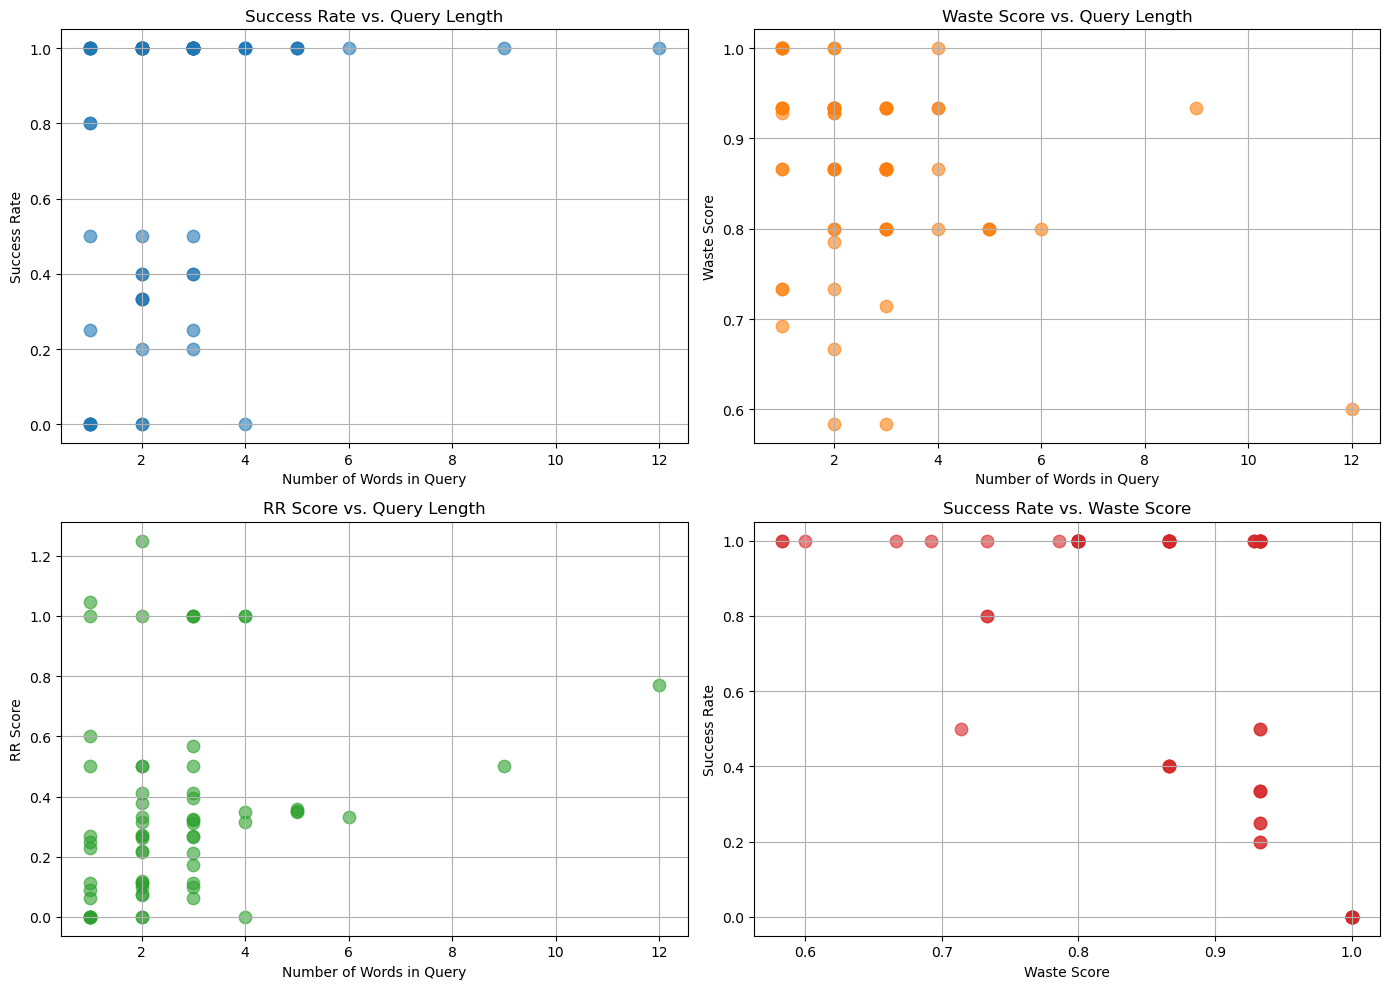

In [59]:
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

axs[0, 0].scatter(df_all_queries["num_words"], df_all_queries["success_rate"], alpha=0.6, s=80)
axs[0, 0].set_title("Success Rate vs. Query Length")
axs[0, 0].set_xlabel("Number of Words in Query")
axs[0, 0].set_ylabel("Success Rate")
axs[0, 0].grid(True)

axs[0, 1].scatter(df_all_queries["num_words"], df_all_queries["waste_score"], alpha=0.6, s=80, color="C1")
axs[0, 1].set_title("Waste Score vs. Query Length")
axs[0, 1].set_xlabel("Number of Words in Query")
axs[0, 1].set_ylabel("Waste Score")
axs[0, 1].grid(True)

axs[1, 0].scatter(df_all_queries["num_words"], df_all_queries["rr_score"], alpha=0.6, s=80, color="C2")
axs[1, 0].set_title("RR Score vs. Query Length")
axs[1, 0].set_xlabel("Number of Words in Query")
axs[1, 0].set_ylabel("RR Score")
axs[1, 0].grid(True)

axs[1, 1].scatter(df_all_queries["waste_score"], df_all_queries["success_rate"], alpha=0.6, s=80, color="C3")
axs[1, 1].set_title("Success Rate vs. Waste Score")
axs[1, 1].set_xlabel("Waste Score")
axs[1, 1].set_ylabel("Success Rate")
axs[1, 1].grid(True)

plt.tight_layout()
plt.show()


In [60]:
# Expectation difficulties
df_difficulties = pd.DataFrame(expectation_difficulties)
df_difficulties.set_index(["test_case", "expectation"], inplace=True)
df_difficulties.sort_values("hitrate", inplace=True)
df_difficulties

hitrate
test_case                                expectation                                                 
Miniprojektin arvostelu                  Kannattaa esitellä tärkein toiminnallisuus, aik...  0.000000
                                         Sprintin maksimi on 2.5 pistettä.                   0.000000
Lean waste (hukka) -käsitteen määritelmä Näin kysymällä toistuvasti (noin viisi kertaa) ...  0.111111
                                         Pyrkimyksenä oli eliminoida kaikki mahdollinen ...  0.222222
                                         Lean-ajattelun taustalla on idea hukan (engl. w...  0.333333
                                         Kaikki ylimääräiset työvaiheet, mitkä eivät ole...  0.444444
Kurssin arviointi                        Kurssilta on jaossa yhteensä 40 pistettä, jotka...  0.545455
                                         Täysiin kurssipisteisiin riittää 90% monivalint...  0.545455
                                         Teoria-asioita arvioidaan                           0.545455
                                         Arvosanaan 1 riittää 20 pistettä, arvosanaan 5 ...  0.636364
Luentojen aikataulu                      Kasper Hirvikoski (Unity)                           0.666667
Kokeen ajankohta                         klo 13-16 A111 ja CHE A110                          0.666667
                                         tiistaina 16.12.                                    0.666667
Luentojen aikataulu                      Luento 2: tiistai 28.10. klo 12-14 B123             0.833333
                                         Luento 1: maanantai 27.10. klo 12-14 B123           0.833333
Kurssin sisältö                          Kurssi koostuu kolmesta komponentista, luennois...  0.833333
                                         Kurssilla käsitellään ohjelmistotuotantoprojekt...  0.833333
Luentojen aikataulu                      Luento 10: tiistai 25.11. klo 12-14 B123            0.833333
Lean waste (hukka) -käsitteen määritelmä Leanin mukaan on olemassa kolmen eri tyypin huk...  0.888889
Esitiedot                                Kurssi on jo ohjelmointia hallitseville tarkoit...  1.000000
                                         Tietokannat ja Web-ohjelmointi (aiemmalta nimel...  1.000000
Miniprojektin hyväksiluku                kerro asiasta emailitse (matti.luukkainen@helsi...  1.000000
                                         ÄLÄ LÄHETÄ MAILIA osoitteeseen kumpula-student@...  1.000000
Miniprojektin arvostelu                  Jokaisesta sprintistä on jaossa ryhmälle 2.5 ku...  1.000000
Hyvä User Story                          INVEST                                              1.000000
                                         As a type of user, I want functionality so that...  1.000000
Esitiedot                                Ohjelmoinnin perusteet ja jatkokurssi               1.000000

In [61]:
# Overall summary
df_overall = pd.DataFrame(avg_metrics)
df_overall.set_index("test_case", inplace=True)
df_overall.sort_values("average_success_rate", ascending=True, inplace=True)
df_overall

,average_success_rate,average_rr_score,average_waste_score
test_case,,,
Miniprojektin arvostelu,0.333333,0.185185,0.933333
Lean waste (hukka) -käsitteen määritelmä,0.400000,0.134049,0.866667
Kurssin arviointi,0.568182,0.210856,0.890909
Kokeen ajankohta,0.666667,0.213302,0.938624
Luentojen aikataulu,0.791667,0.335813,0.695543
Kurssin sisältö,0.833333,0.221032,0.888889
Esitiedot,1.000000,0.798701,0.931973
Miniprojektin hyväksiluku,1.000000,0.979091,0.866667
Hyvä User Story,1.000000,0.400298,0.766667


In [62]:
df_overall.mean()

average_success_rate    0.732576
average_rr_score        0.386481
average_waste_score     0.864364
dtype: float64